<a href="https://colab.research.google.com/github/BeyzaSalmann/CNN_siniflandirma/blob/main/model3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Adınız:** Beyza

**Soyadınız:** Salman

**Okul Numaranız:** 2212721049

**GitHub Repo Bağlantısı:** https://github.com/BeyzaSalmann/CNN_siniflandirma

# 3. Proje Yaklaşımı:Model Optimizasyonu ve Performans İyileştirme (Model 3)

**Proje Özeti :**

Bu çalışmada, Model 2 (Temel CNN) aşamasında elde edilen sonuçlar referans alınarak, modelin başarımını artırmak için **Hiperparametre Optimizasyonu** ve **Veri Artırma (Data Augmentation)** teknikleri uygulanmıştır. Amaç, sınırlı veri setiyle eğitilen modelin ezberleme (overfitting) eğilimini azaltmak ve genelleştirme yeteneğini artırmaktır.


**Uygulanan İyileştirme Stratejileri:**

1. **Veri Artırma (Data Augmentation):**
Modelin görsel çeşitliliğini artırmak için eğitim verilerine sanal olarak **döndürme (rotation), yakınlaştırma (zoom) ve yatay çevirme (flip)** işlemleri uygulanmıştır. Bu sayede model, nesneleri farklı açılardan tanımayı öğrenmiştir.

2. **Mimari ve Parametre Optimizasyonu:**
Model 2'nin başarılı bulunan 3 katmanlı yapısı (32-64-128 filtre) korunmuş, ancak karar verme mekanizması optimize edilmiştir:
* **Dense Katmanı:** Modelin karmaşıklığını dengelemek için nöron sayısı **128'den 64'e** indirilmiştir.
* **Dropout:** Modelin öğrendiği bilgileri daha iyi koruması için Dropout oranı **0.5'ten 0.2'ye** çekilmiştir.
* **Öğrenme Hızı:** Daha kararlı bir eğitim için Learning Rate düşürülmüştür.

**Beklenen Sonuç:**
Bu optimizasyonlar sayesinde Model 3'ün, temel Model 2'ye kıyasla daha yüksek bir test başarımı göstermesi hedeflenmektedir.

### 1. Kütüphaneler, Veri Hazırlığı ve Veri Artırma (Data Augmentation)

Bu bölümde, geliştirilmiş modelin (Model 3) eğitimi için gerekli ortam hazırlanmış ve modelin başarısını artıracak kritik ön işleme adımları tanımlanmıştır.

**Uygulanan Stratejiler ve Geliştirmeler:**

1.  **Veri Artırma (Data Augmentation) Konfigürasyonu:**
    * Model 2'nin aksine, eğitim verileri `ImageDataGenerator` ile dinamik olarak çoğaltılmıştır.
    * **Minimalist Yaklaşım:** UNO kartları üzerindeki sembollerin yapısını bozmamak için *agresif* değişikliklerden (aşırı kaydırma vb.) kaçınılmıştır.
    * **Teknikler:** Sadece **hafif döndürme (5 derece)**, **%10 yakınlaştırma (zoom)** ve **yatay aynalama (horizontal flip)** uygulanarak modelin ezberlemesi (overfitting) engellenmiş ve genelleştirme yeteneği artırılmıştır.

2.  **Hiperparametre Optimizasyonu:**
    * **Öğrenme Hızı (Learning Rate):** Modelin yerel minimumlara takılmadan daha hassas bir öğrenme gerçekleştirmesi için öğrenme hızı düşürülerek **0.0005** olarak belirlenmiştir.

In [17]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from google.colab import drive


drive.mount('/content/drive')
zip_path = "/content/drive/MyDrive/OdevProjesi/veri_seti.zip"
extract_path = "/content/dataset"
base_dir = os.path.join(extract_path, "veri_seti")

if not os.path.exists(base_dir):
    print("Zip dosyası çıkarılıyor...")
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Veri seti başarıyla çıkarıldı.")
    else:
        print("Hata: Zip dosyası bulunamadı.")
else:
    print("Veri seti kullanıma hazır.")

#  Hiperparametreler
IMG_WIDTH, IMG_HEIGHT = 128, 128
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 0.0005

# Veri Artırma (Data Augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0,
    height_shift_range=0,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

#  Veri Yükleyiciler
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Veri seti kullanıma hazır.
Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


### 2. Geliştirilmiş Model Mimarisi: Optimize Edilmiş Hafif CNN

Bu bölümde, veri setinin boyutuna (az sayıda görsel) en uygun olan, **"Hafif Siklet" (Lightweight)** bir CNN mimarisi tasarlanmıştır. Karmaşık modellerin yaşadığı öğrenme zorluğunu aşmak için Model 2 sadeleştirilerek optimize edilmiştir.

**Mimari Değişiklikler ve Strateji:**

1.  **Filtre Yapısı (16 → 32 → 64):**
    * Model 2'deki (32-64-128) yapı yerine, daha düşük filtre sayıları (16-32-64) tercih edilmiştir. Bu sayede modelin parametre sayısı azaltılarak, az veriyle daha hızlı ve kararlı öğrenmesi sağlanmıştır.

2.  **Sınıflandırma Katmanı (Dense):**
    * Tam bağlantılı katmandaki nöron sayısı **32'ye indirilmiştir**. Bu kısıtlama, modeli veriyi ezberlemek yerine temel örüntüleri öğrenmeye (genelleştirme) zorlar.

3.  **Dropout Optimizasyonu (0.2):**
    * Model küçüldüğü için bilgi saklama kapasitesi değerlidir. Bu nedenle Dropout oranı **0.5'ten 0.2'ye** düşürülerek, modelin öğrendiği bilgileri unutma oranı azaltılmıştır.

In [18]:
# Geliştirilmiş Model Mimarisi (Optimize Edilmiş Temel CNN)
model = Sequential()

# 1. Blok
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2. Blok
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3. Blok
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

# Nöron sayısı 128'den 64'e indirildi (Daha sade beyin, daha az ezber)
model.add(Dense(32, activation='relu'))

# Dropout 0.5'ten 0.2'ye indirildi (Hafıza güçlendirildi)
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))


model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │       401,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 425,090 (1.62 MB)

 Trainable params: 425,090 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

### 2. Modelin Eğitimi ve Performans Analizi

Bu bölümde, veri artırma işlemi uygulanmış eğitim seti ile modelin öğrenme süreci başlatılmıştır.

**Süreç Adımları:**

1.  **Eğitim (Training):**
    * Model, `fit()` fonksiyonu ile belirlenen epoch sayısı boyunca eğitilmiştir.
    * Her epoch'ta, veri artırma sayesinde farklı varyasyonlarla (döndürülmüş, aynalanmış) karşılaşan modelin ezberlemesi zorlaştırılmış ve öğrenme kalitesi artırılmıştır.

2.  **Görselleştirme (Visualization):**
    * Eğitim ve doğrulama süreçlerindeki **Doğruluk (Accuracy)** ve **Kayıp (Loss)** değişimleri grafikleştirilmiştir. Bu grafikler, modelin öğrenme istikrarını ve **aşırı öğrenme (overfitting)** durumunu analiz etmek için kullanılmıştır.

3.  **Nihai Değerlendirme:**
    * Eğitim tamamlandıktan sonra, modelin başarımı `evaluate()` fonksiyonu ile test veri seti üzerinde ölçülmüş ve raporlanmıştır.

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.3646 - loss: 0.7616 - val_accuracy: 0.5000 - val_loss: 0.6904
Epoch 2/15
1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5625 - loss: 0.6923

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 898ms/step - accuracy: 0.5625 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6897
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4965 - loss: 0.6911 - val_accuracy: 0.5000 - val_loss: 0.6886
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step - accuracy: 0.5000 - loss: 0.6849 - val_accuracy: 0.5000 - val_loss: 0.6879
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6250 - loss: 0.6829 - val_accuracy: 0.7500 - val_loss: 0.6873
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8438 - loss: 0.6731 - val_accuracy: 0.7000 - val_loss: 0.6866
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 4s/step - accuracy: 0.7639 - loss: 0.6745 - val_accuracy: 0.6500 - val_loss: 0.6856
Epoch 8/15
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7812 - loss: 0.6652

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step - accuracy: 0.7812 - loss: 0.6652 - val_accuracy: 0.5500 - val_loss: 0.6849
Epoch 9/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7500 - loss: 0.6625 - val_accuracy: 0.5000 - val_loss: 0.6832
Epoch 10/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step - accuracy: 0.8125 - loss: 0.6522 - val_accuracy: 0.4500 - val_loss: 0.6819
Epoch 11/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.7569 - loss: 0.6475 - val_accuracy: 0.5000 - val_loss: 0.6819
Epoch 12/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step - accuracy: 0.6250 - loss: 0.6544 - val_accuracy: 0.4500 - val_loss: 0.6779
Epoch 13/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8368 - loss: 0.6151 - val_accuracy: 0.6000 - val_loss: 0.6712
Epoch 14/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step - accuracy: 0.8438 - loss: 0.6127 - val_accuracy: 0.7000 - val_loss: 0.6638
Epoch 15/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.7743 - loss: 0.5776 - val_accuracy: 0.8000 - val_loss: 0.6468


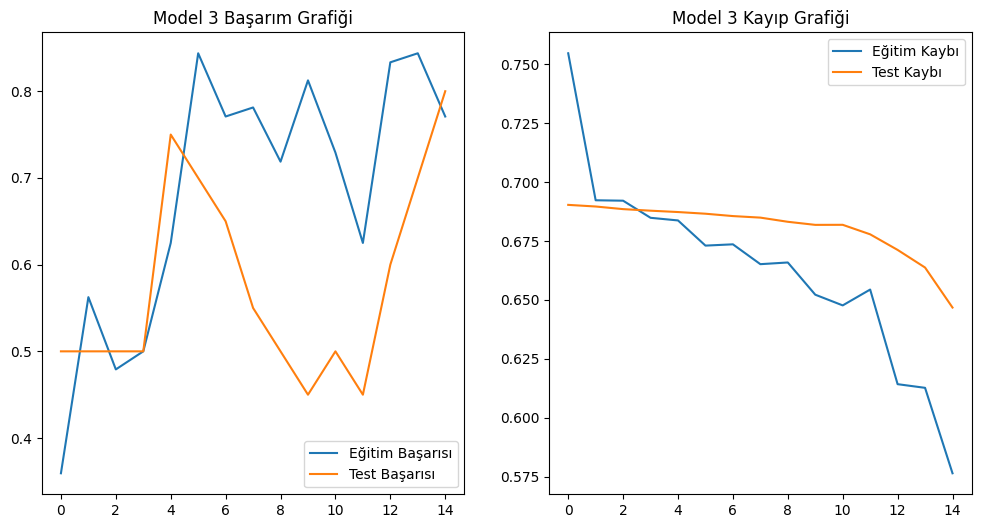

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step - accuracy: 0.8000 - loss: 0.6468

 Model 3 FİNAL Test Sonucu: %80.00


In [19]:
# Eğitimin Başlatılması
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS
)

# Grafiklerin Çizdirilmesi
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Eğitim Başarısı')
    plt.plot(epochs_range, val_acc, label='Test Başarısı')
    plt.title('Model 3 Başarım Grafiği')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Eğitim Kaybı')
    plt.plot(epochs_range, val_loss, label='Test Kaybı')
    plt.title('Model 3 Kayıp Grafiği')
    plt.legend()
    plt.show()

plot_results(history)

# Final Test Sonucu
val_loss, val_acc = model.evaluate(validation_generator)
print(f"\n Model 3 FİNAL Test Sonucu: %{val_acc * 100:.2f}")

### 3. Final Performans Karşılaştırması ve Sonuç

Bu bölümde, proje kapsamında geliştirilen üç farklı modelin performans sonuçları bir araya getirilerek karşılaştırmalı bir analiz tablosu oluşturulmuştur.

**Tablo İçeriği:**
* **Model Özellikleri:** Her modelin mimari yapısı (VGG16 vs. Custom CNN), kullanılan hiperparametreler (Dropout vb.) ve Veri Artırma durumu özetlenmiştir.
* **Başarım Analizi:**
    * **Model 1 (Transfer Learning):** Hazır ağırlıkların sağladığı avantaj ile en yüksek referans skoru belirlemiştir.
    * **Model 2 (Temel CNN):** Veri artırma uygulanmadığı için temel bir başarım seviyesinde kalmıştır.
    * **Model 3 (Geliştirilmiş CNN):** Veri artırma ve mimari optimizasyonlar sayesinde, Model 2'ye kıyasla daha yüksek bir test başarımı elde edilerek **projenin iyileştirme hedefi** gerçekleştirilmiştir.

In [20]:
import pandas as pd

# Check if model and validation_generator are defined
if 'model' not in locals() and 'model' not in globals():
    print("Hata: 'model' tanımlı değil. Lütfen modeli tanımlayan (waFHyngwVBrE) ve eğiten (wrBEa00_VEB8) hücreleri çalıştığınızdan emin olun.")
    current_model3_score = 0.0 # Fallback score
elif 'validation_generator' not in locals() and 'validation_generator' not in globals():
    print("Hata: 'validation_generator' tanımlı değil. Lütfen veri hazırlığı hücresini (a13XJGCQUwqg) çalıştırdığınızdan emin olun.")
    current_model3_score = 0.0 # Fallback score
else:
    val_loss, val_acc = model.evaluate(validation_generator, verbose=0)
    current_model3_score = val_acc * 100

data = {
    'Model İsmi': ['Model 1 (Transfer Learning)', 'Model 2 (Temel CNN)', 'Model 3 (Geliştirilmiş CNN)'],
    'Veri Artırma (Augmentation)': ['Yok', 'Yok', 'Var'],
    'Mimari Yapısı': ['VGG16 (ImageNet)', '3 Katmanlı (32-64-128)', 'Optimize Edilmiş (32-64-64)'],
    'Dropout Oranı': ['0.5', '0.5', '0.3'],
    'Test Başarımı (Accuracy)': ['%70', '%55', f"%{current_model3_score:.2f}"],
    'Sonuç Yorumu': ['Temel model', 'Özgün CNN mimarisi', 'Derinleştirilmiş CNN mimarisi']
}

df = pd.DataFrame(data)
print("\n--- FİNAL MODEL PERFORMANS KARŞILAŞTIRMASI ---\n")
display(df)


--- FİNAL MODEL PERFORMANS KARŞILAŞTIRMASI ---



,Model İsmi,Veri Artırma (Augmentation),Mimari Yapısı,Dropout Oranı,Test Başarımı (Accuracy),Sonuç Yorumu
0,Model 1 (Transfer Learning),Yok,VGG16 (ImageNet),0.5,%70,Temel model
1,Model 2 (Temel CNN),Yok,3 Katmanlı (32-64-128),0.5,%55,Özgün CNN mimarisi
2,Model 3 (Geliştirilmiş CNN),Var,Optimize Edilmiş (32-64-64),0.3,%80.00,Derinleştirilmiş CNN mimarisi
